<a href="https://www.kaggle.com/code/yannicksteph/cnn-mnist-classification-with-cnn?scriptVersionId=137784998" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Classification of MNIST Dataset Using Convolutional Neural Networks (CNN)

This notebook delves into a classification task involving the use of Convolutional Neural Networks (CNNs) on the famous MNIST dataset, available at [Yann LeCun's website](http://yann.lecun.com/exdb/mnist/).

We have structured the notebook into two main sections:

## Objectives
This section delineates the specific goals of this notebook, which are:

- Training a Deep Neural Network (DNN) model to achieve high accuracy in recognizing handwritten digits.

## Implementation
This section presents the hands-on steps necessary to attain the previously mentioned objectives. These steps include:

1. **Imports, Constants, and Methods:** Setting up the necessary libraries, constants, and methods for our task.
2. **Data Retrieval:** Acquiring the MNIST dataset to be used for training and testing purposes.
3. **Data Preparation:** Preprocessing and setting up the dataset to facilitate effective training of the CNN model.
4. **Model Creation:** Architecting and constructing the CNN model utilizing Keras.
5. **Model Training:** Engaging the CNN model in learning using the prepared dataset.
6. **Evaluation:** Gauging the trained model's performance and analyzing the classification results.

## 1. Imports & Constants & Methods

### 1.1 - Imports

In [1]:
!pip install visualkeras

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import sys,os

from importlib import reload

import math
import sklearn.metrics
import itertools
from sklearn.preprocessing import MinMaxScaler

import visualkeras

import warnings  # For ignoring warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 13.1 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

### 1.2 Constants

To customize the dataset generation, you have the option to perform tests or generate the entire enhanced dataset by adjusting the following parameters:

For the current training configuration:
- `batch_size`: Which determines the number of samples processed in each training iteration.
- `epochs`: Indicating the total number of times the model will be trained on the entire dataset.

Verbosity during training:
- 0: Silent mode, no output will be displayed during training.
- 1: Progress bar mode, a progress bar will be displayed to show the progress of each epoch.
- 2: One line per epoch mode, a concise summary will be displayed for each epoch.

In [2]:
# Test
# ----
# batch_size  = 256
# epochs      =  8

# Best
# ----
batch_size  = 512
epochs      =  16

# Verbosity
# ----
fit_verbosity = 1

### 1.3 Methods

In [3]:
def show_images(
    images, 
    labels=None, 
    indices='all', 
    columns=12, 
    figure_size=(1, 1),                
    show_colorbar=False, 
    y_pred=None, 
    color_map='binary',
    normalization=None, 
    padding=0.35, 
    spines_alpha=1, 
    font_size=20,
    interpolation='lanczos'
):
    """
    Show a grid of images with labels.

    Args:
        images: The images to display. Shapes must be (-1, lx, ly), (-1, lx, ly, 1), or (-1, lx, ly, 3).
        labels: Real classes or labels associated with the images. (None)
        indices: Indices of images to show or 'all' for all images. ('all')
        columns: Number of columns in the grid. (12)
        figure_size: Size of the figure (width, height). (1, 1)
        show_colorbar: Whether to show the colorbar. (False)
        predicted_labels: Predicted classes associated with the images. (None)
        color_map: Matplotlib color map to use. ('binary')
        normalization: Matplotlib imshow normalization. (None)
        padding: Padding between rows in the grid. (0.35)
        spines_alpha: Alpha value for the spines. (1)
        font_size: Font size in pixels. (20)
        interpolation: Interpolation method for displaying the images. ('lanczos')

    Returns:
        None
    """
    if indices == 'all':
        indices = range(len(images))

    if normalization and len(normalization) == 2:
        normalization = matplotlib.colors.Normalize(vmin=normalization[0], vmax=normalization[1])

    draw_labels = (labels is not None)
    draw_predicted_labels = (y_pred is not None)

    rows = math.ceil(len(indices) / columns)
    fig = plt.figure(figsize=(columns * figure_size[0], rows * (figure_size[1] + padding)))

    n = 1
    for i in indices:
        axs = fig.add_subplot(rows, columns, n)
        n += 1

        # ---- Shape is (lx,ly)
        if len(images[i].shape) == 2:
            xx = images[i]
        # ---- Shape is (lx,ly,n)
        if len(images[i].shape) == 3:
            (lx, ly, lz) = images[i].shape
            if lz == 1:
                xx = images[i].reshape(lx, ly)
            else:
                xx = images[i]

        img = axs.imshow(xx, cmap=color_map, norm=normalization, interpolation=interpolation)

        axs.spines['right'].set_visible(True)
        axs.spines['left'].set_visible(True)
        axs.spines['top'].set_visible(True)
        axs.spines['bottom'].set_visible(True)

        axs.spines['right'].set_alpha(spines_alpha)
        axs.spines['left'].set_alpha(spines_alpha)
        axs.spines['top'].set_alpha(spines_alpha)
        axs.spines['bottom'].set_alpha(spines_alpha)

        axs.set_yticks([])
        axs.set_xticks([])

        if draw_labels and not draw_predicted_labels:
            axs.set_xlabel(labels[i], fontsize=font_size)
        if draw_labels and draw_predicted_labels:
            if labels[i] != y_pred[i]:
                axs.set_xlabel(f'{y_pred[i]} ({labels[i]})', fontsize=font_size)
                axs.xaxis.label.set_color('red')
            else:
                axs.set_xlabel(labels[i], fontsize=font_size)

        if show_colorbar:
            fig.colorbar(img, orientation="vertical", shrink=0.65)

    plt.show()

    
def show_history(
    history, 
    figsize=(8,6), 
    plot={"Accuracy":['accuracy','val_accuracy'], 'Loss':['loss', 'val_loss']}
):
    """
    Show history
    args:
        history: history
        figsize: fig size
        plot: list of data to plot : {<title>:[<metrics>,...], ...}
    """
    fig_id=0
    for title,curves in plot.items():
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.ylabel(title)
        plt.xlabel('Epoch')
        for c in curves:
            plt.plot(history.history[c])
        plt.legend(curves, loc='upper left')
        plt.show()
        
        
def show_confusion_matrix(
    y_true,
    y_pred,
    target_names,
    title='Confusion matrix',
    cmap=None,
    normalize=True,
    figsize=(10, 8),
    digit_format='{:0.2f}'
):
    cm = sklearn.metrics.confusion_matrix( y_true,y_pred, normalize=None, labels=target_names)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, digit_format.format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
        

## 2. Retrieve data

In this step, we will be loading the following subsets of our dataset:

- **Train** subset: This forms our training dataset, which will be used to train the model. We'll refer to the input and output data as `x_train` and `y_train` respectively.
- **Test** subset: This is our validation dataset, used to evaluate the performance of the model during and after training. The input and output data for this subset will be referred to as `x_test` and `y_test`.

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
y_train shape: (60000,)
x_test shape: (10000, 28, 28, 1)
y_test shape: (10000,)


## 3. Preparing the data

In [5]:
print('Before normalization : Min={}, max={}'.format(x_train.min(),x_train.max()))

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train.reshape(-1, 1)).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(-1, 1)).reshape(x_test.shape)

print('After normalization : Min={}, max={}'.format(x_train.min(), x_test.max()))

Before normalization : Min=0, max=255
After normalization : Min=0.0, max=1.0


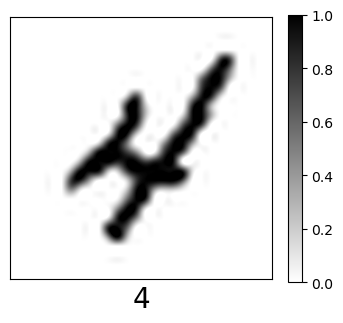

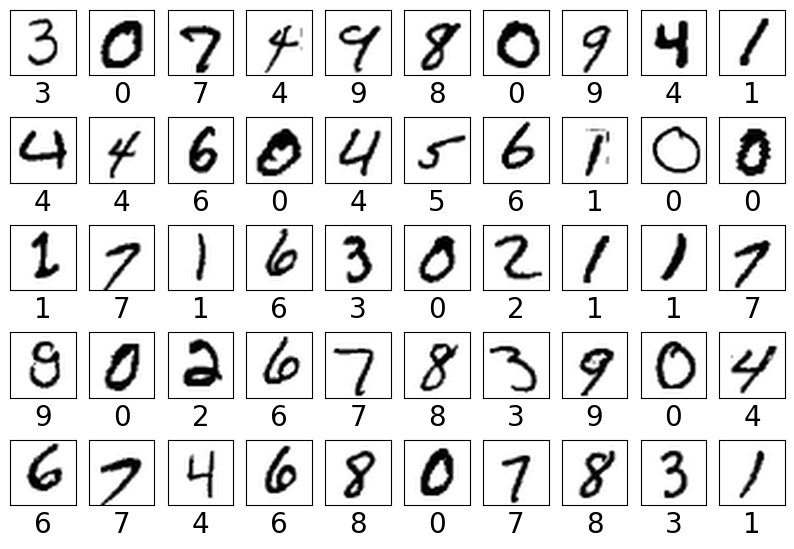

In [6]:
show_images(x_train, y_train, [9], figure_size = (5,5 ), show_colorbar=True)
show_images(x_train, y_train, range(50,100), columns=10)

## 4. Create model

Information about:
- [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers): Determines how the model is updated based on the gradients computed during training.
- [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations): Determines the shape of the output from a neural network layer. It adds non-linearity to the model.
- [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses): Measures how different the model's predictions are from the target values. It is used to guide the model's optimization.
- [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics): Measures used to evaluate the performance of the model, such as accuracy, precision, recall, etc.

In [7]:
model = keras.models.Sequential()

model.add( keras.layers.Input((28,28,1)) )

model.add( keras.layers.Conv2D(8, (3,3),  activation='relu') )
model.add( keras.layers.MaxPooling2D((2,2)))
model.add( keras.layers.Dropout(0.2))

model.add( keras.layers.Conv2D(16, (3,3), activation='relu') )
model.add( keras.layers.MaxPooling2D((2,2)))
model.add( keras.layers.Dropout(0.2))

model.add( keras.layers.Flatten()) 
model.add( keras.layers.Dense(100, activation='relu'))
model.add( keras.layers.Dropout(0.5))

model.add( keras.layers.Dense(10, activation='softmax'))

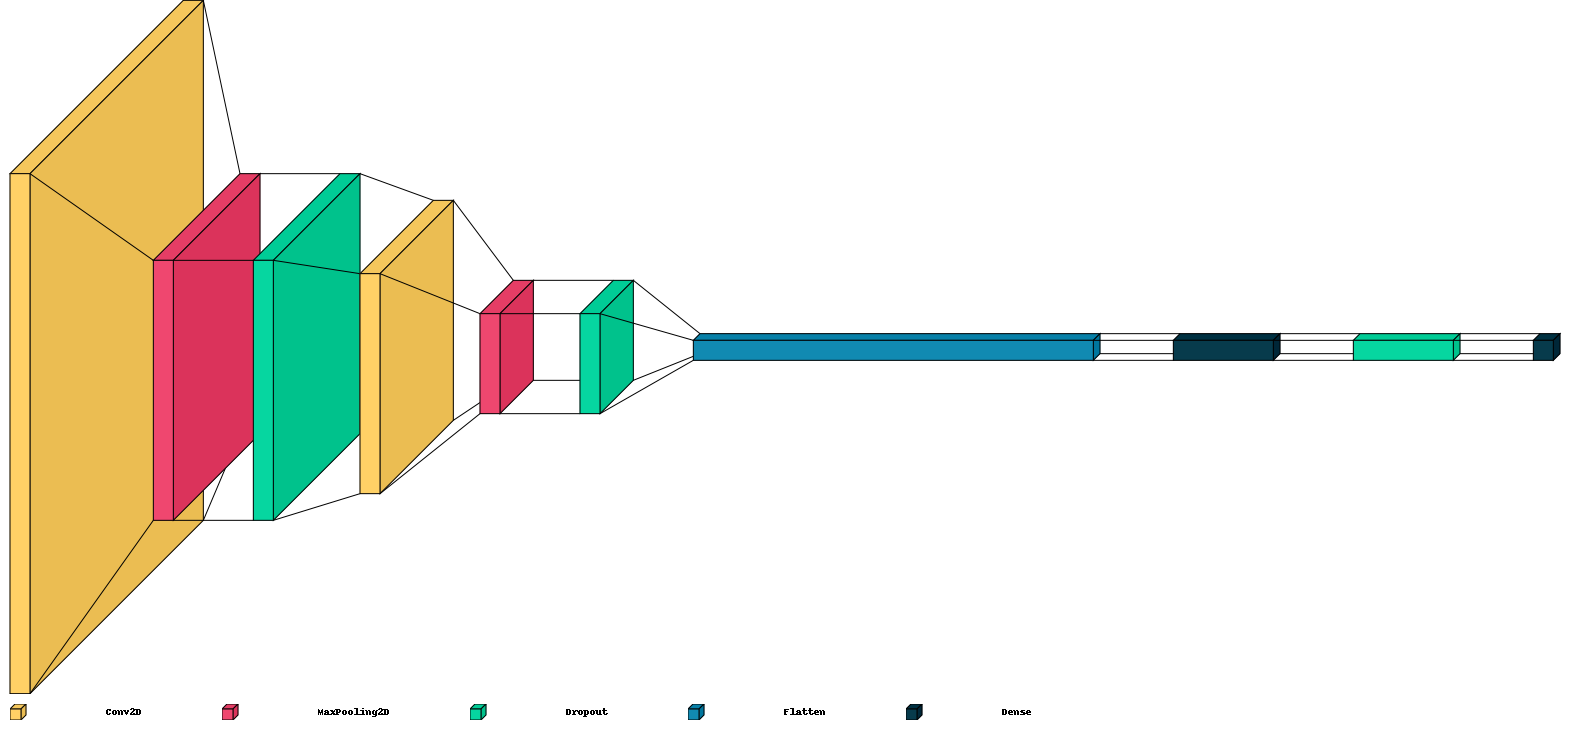

In [8]:
visualkeras.layered_view(model, legend=True, scale_z=1, scale_xy =20, spacing=80)

In [9]:
model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 8)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 16)          0

## 5. Train the model

In [10]:
history = model.fit(  x_train, y_train,
                      batch_size      = batch_size,
                      epochs          = epochs,
                      verbose         = fit_verbosity,
                      validation_data = (x_test, y_test))

Epoch 1/16


2023-07-24 20:07:10.949843: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


118/118 [==============================] - 11s 9ms/step - loss: 1.0883 - accuracy: 0.6428 - val_loss: 0.2717 - val_accuracy: 0.9266
Epoch 2/16
118/118 [==============================] - 1s 6ms/step - loss: 0.3851 - accuracy: 0.8805 - val_loss: 0.1579 - val_accuracy: 0.9535
Epoch 3/16
118/118 [==============================] - 1s 6ms/step - loss: 0.2868 - accuracy: 0.9117 - val_loss: 0.1190 - val_accuracy: 0.9640
Epoch 4/16
118/118 [==============================] - 1s 6ms/step - loss: 0.2346 - accuracy: 0.9281 - val_loss: 0.0954 - val_accuracy: 0.9700
Epoch 5/16
118/118 [==============================] - 1s 6ms/step - loss: 0.2044 - accuracy: 0.9376 - val_loss: 0.0838 - val_accuracy: 0.9727
Epoch 6/16
118/118 [==============================] - 1s 6ms/step - loss: 0.1837 - accuracy: 0.9444 - val_loss: 0.0730 - val_accuracy: 0.9771
Epoch 7/16
118/118 [==============================] - 1s 7ms/step - loss: 0.1724 - accuracy: 0.9472 - val_loss: 0.0677 - val_accuracy: 0.9774
Epoch 8/16
118/1

## 6. Evaluate
### 6.1. Final loss and accuracy
Note : With a DNN, we had a precision of the order of : 97.7%

In [11]:
score = model.evaluate(x_test, y_test, verbose=0)

print(f'Test loss     : {score[0]:4.4f}')
print(f'Test accuracy : {score[1]:4.4f}')

Test loss     : 0.0423
Test accuracy : 0.9863


### 6.2. Plot history

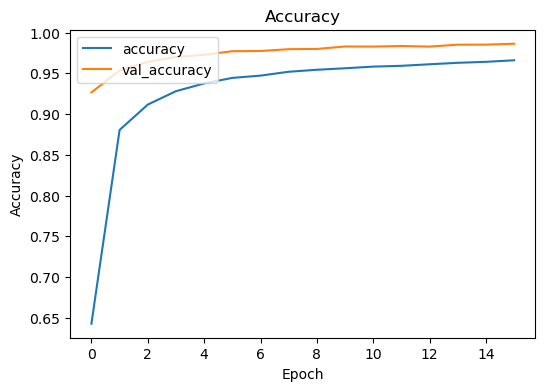

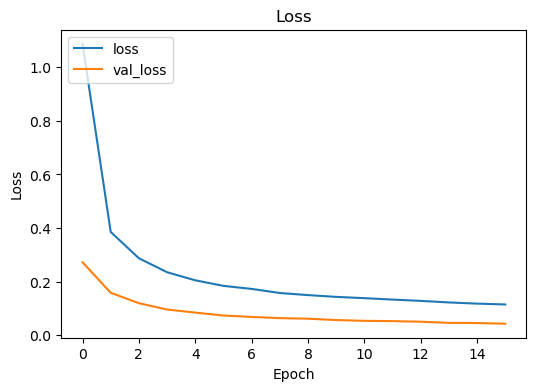

In [12]:
show_history(history, figsize=(6,4))

### 6.3. Plot results

313/313 [==============================] - 1s 2ms/step


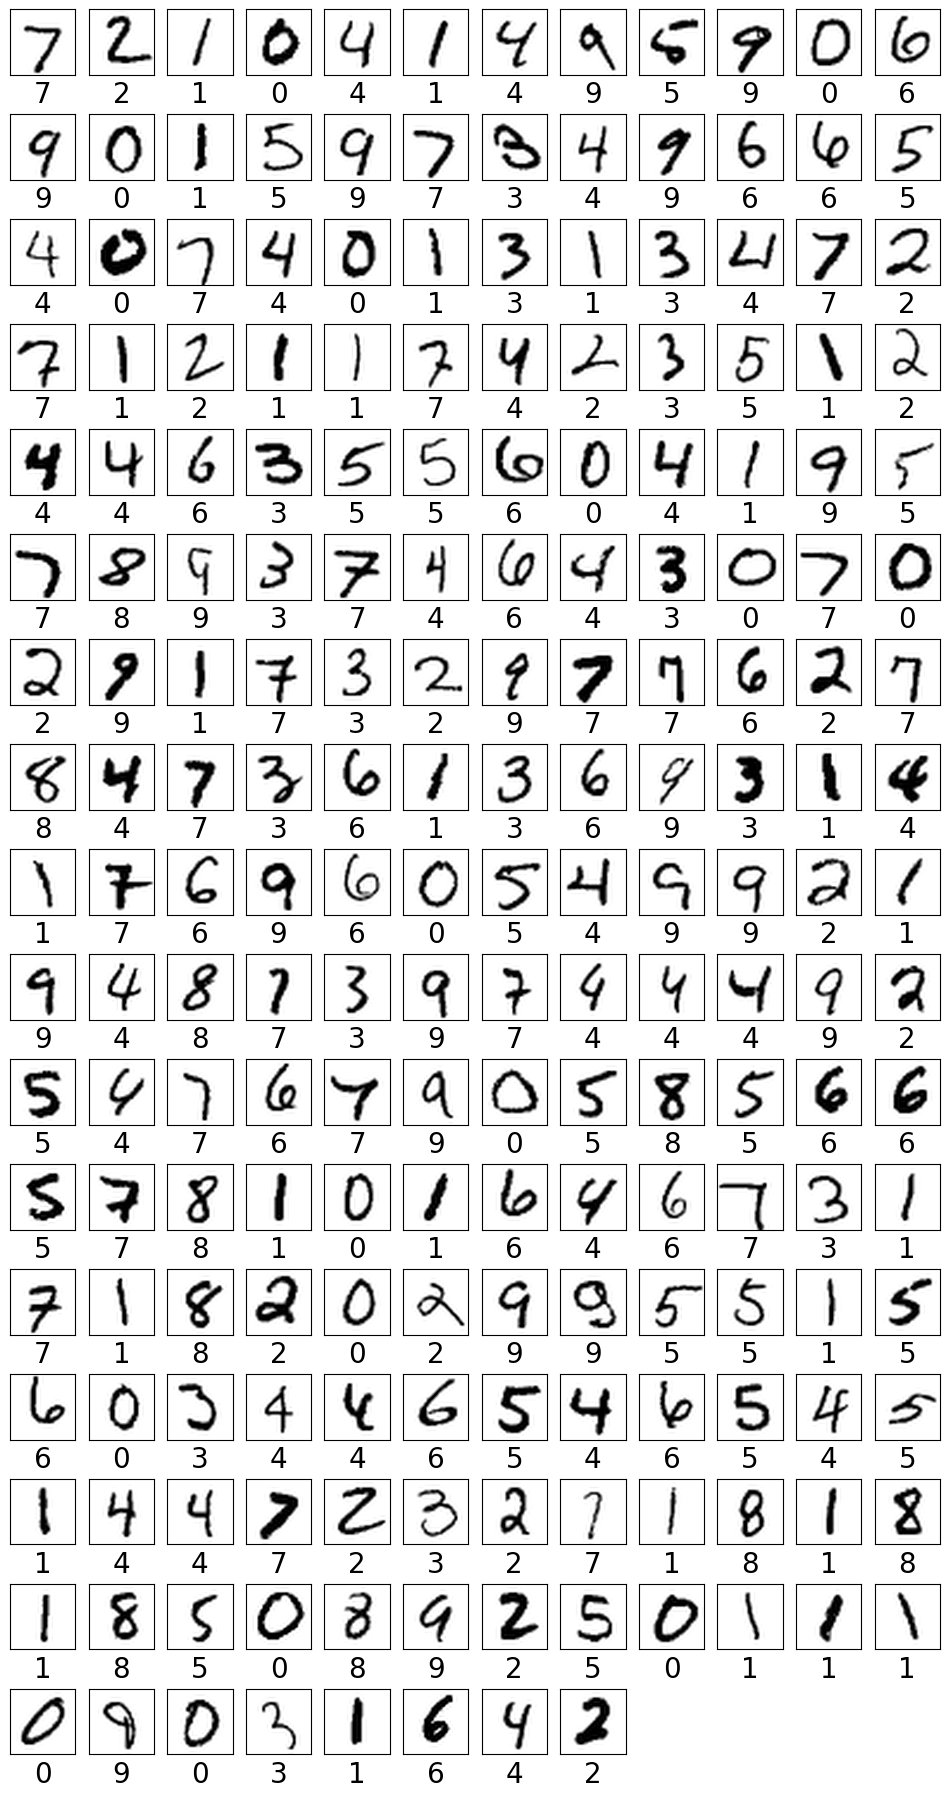

In [13]:
y_probabilities = model.predict(x_test)
y_pred    = np.argmax(y_probabilities, axis=-1)


show_images(x_test, y_test, range(0,200), columns=12, figure_size = (1,1), y_pred=y_pred)

### 6.4. Plot some errors

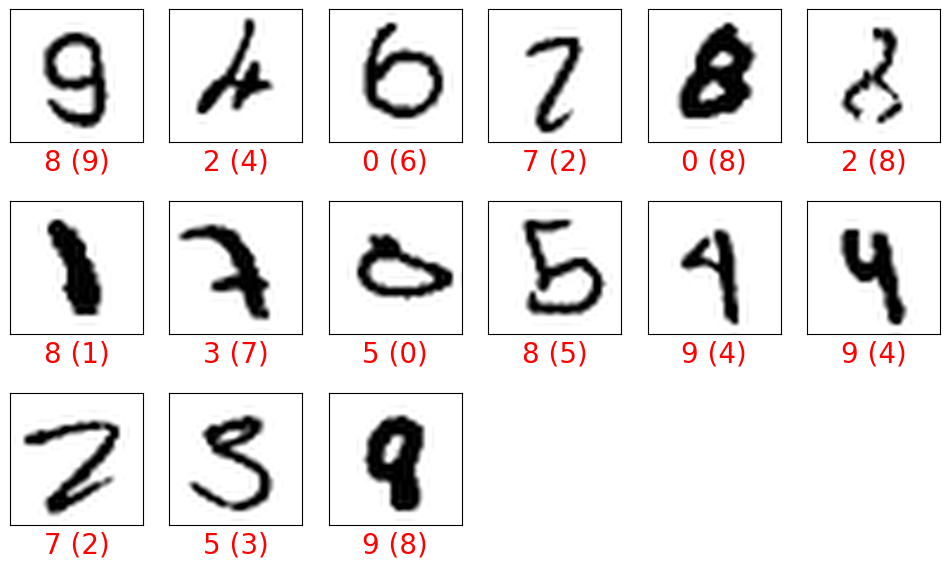

In [14]:
errors=[ i for i in range(len(x_test)) if y_pred[i]!=y_test[i] ]
errors=errors[:min(24,len(errors))]
show_images(x_test, y_test, errors[:15], columns=6, figure_size = (2,2), y_pred=y_pred)

### 6.5. Confusion Matrix

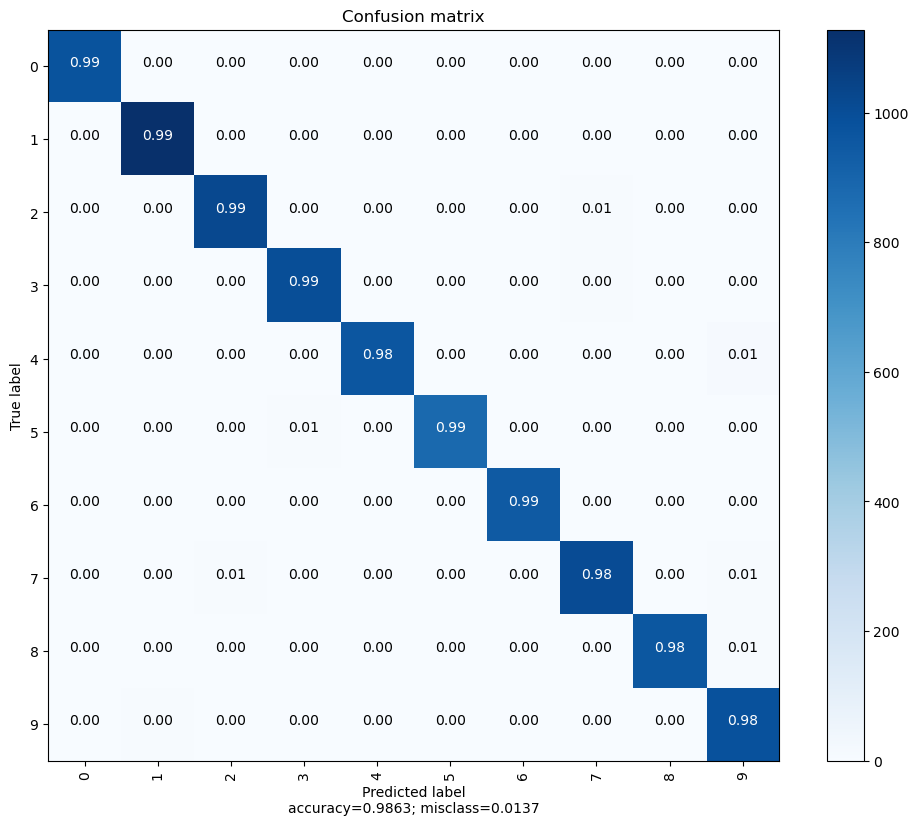

In [15]:
show_confusion_matrix(y_test,y_pred,range(10),normalize=True)

## References

The creation of this document was greatly influenced by the following key sources of information:

1. [Yann LeCun's website](http://yann.lecun.com/exdb/mnist/) - This is the official site for the MNIST dataset, providing crucial details about the data structure and its applications.
2. [Keras Datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets) - An invaluable resource for accessing and understanding various Keras datasets, including MNIST.
3. [Fidle](https://gricad-gitlab.univ-grenoble-alpes.fr/talks/fidle/-/wikis/home) - An informative guide that provides in-depth explanations and examples on various data science topics.